In [12]:
import pandas as pd
import seaborn as sns
import numpy as np

from collections import Counter

In [4]:
# load dataframe
infile = '../data/full-udrp-parsed-proceedings.jsonl.gz'

df = pd.read_json(
    infile, 
    lines = True, 
    convert_dates=['submitted', 'commenced', 'panel_appointed', 'published']
)

# drop lines with inconsistent values
focDf = df[(df.submitted >= "1999-12-31") & (df.published >= df.submitted)].copy()

# estimate the delays
focDf['commencement_delay'] = (focDf.commenced - focDf.submitted).dt.days
focDf['appointment_delay'] = (focDf.panel_appointed - focDf.commenced).dt.days
focDf['decision_delay'] = (focDf.published - focDf.panel_appointed).dt.days
focDf['overall_delay'] = (focDf.published - focDf.submitted).dt.days
focDf['panel_size'] = focDf.panelists.apply(lambda x: 'one' if len(x) == 1 else ('three' if len(x) == 3 else None))

### Registrar delay to answer providers' verification requests

Text(0.5, 0, 'Domain names')

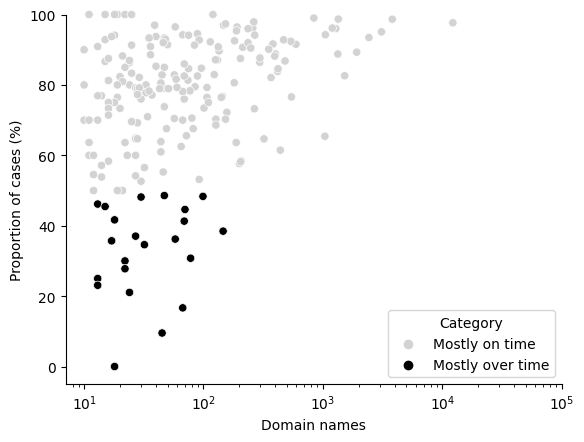

In [ ]:
regDf = focDf.loc[
    (focDf.registrars.apply(lambda x: len(x) == 1)) & 
    (focDf.source.isin(['WIPO', 'FORUM'])) & 
    (~focDf[['registrar_request_date', 'registrar_response_date']].isna().any(axis = 1)) & 
    (focDf.registrar_response_date >= focDf.registrar_request_date) & 
    (focDf.registrar_response_date <= focDf.commenced), :
].copy()
regDf['registrar'] = regDf.registrars.apply(lambda x: x[0])
regDf['registrar_delay'] = regDf.apply(lambda x: len(pd.bdate_range(x.registrar_request_date, x.registrar_response_date)), axis = 1)

# accept up to 3 business days
regStats = regDf.groupby('registrar').agg({'registrar_delay': lambda x: 100 * (Counter(x)[0] + Counter(x)[1] + Counter(x)[2] + Counter(x)[3]) / len(x), 'number': 'nunique', 'domains': lambda x: len(set().union(*x.values))}).reset_index()

regStats['Category'] = np.where(regStats.registrar_delay >= 50, "Mostly on time", "Mostly over time")
regStats['reg_status'] = 'Functional'

ax = sns.scatterplot(regStats[regStats.number >= 10], x = 'domains', y = 'registrar_delay', hue = 'Category', hue_order = ["Mostly on time", "Mostly over time"], palette=['lightgrey', 'black'], clip_on = False)
ax.set_xscale('log')
ax.set_ylim(top = 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(right = 100000)

ax.set_ylabel('Proportion of cases (%)')
ax.set_xlabel('Domain names')

### Providers' delay to appoint panelists

### Panelists' delays in rendering decisions

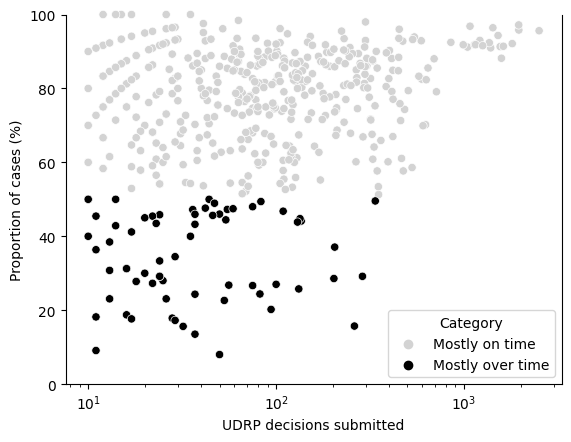

In [21]:
pan_arr = sum([[(
        row.number, panelist, row.decision_delay, 
        row.panel_size, row.status, row.panel_appointed, 
        row.published, len(row.domains)
    ) for panelist in row.panelists
] for _, row in focDf[focDf.source.isin(['WIPO', 'FORUM'])].iterrows()], [])


panDf = pd.DataFrame(
    pan_arr, 
    columns = [
        'number', 'panelist', 'decision_delay', 
        'panel_size', 'status', 'appointment', 
        'decision', 'n_domains'
        ]
    )

panDf['on_time'] = panDf.decision_delay <= 15

pan_stats = panDf.groupby('panelist').agg({'number': 'nunique', 'on_time': 'sum'})
pan_stats['overtime'] = 100 * pan_stats.on_time / pan_stats.number
pan_stats['category'] = np.where(pan_stats.overtime > 50, 'Mostly on time', 'Mostly over time')

ax = sns.scatterplot(pan_stats[pan_stats.number >= 10], x = 'number', y = 'overtime', hue = 'category', hue_order=['Mostly on time', 'Mostly over time'], palette=['lightgrey', 'black'], clip_on = False)
ax.legend(title = 'Category')
ax.set_ylabel('Proportion of cases (%)')
ax.set_xlabel('UDRP decisions submitted')

# ax.set_xlim(right = 2500)
ax.set_ylim(top = 100, bottom = 0)

ax.spines['top'].set_visible(False)
for ed in ('top', 'right'):
    ax.spines[ed]
ax.set_xscale('log')

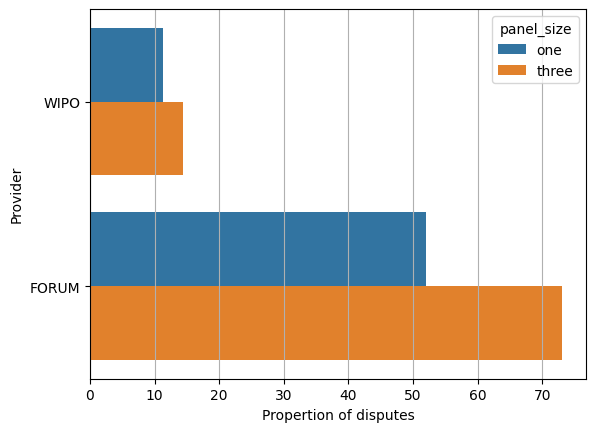

In [18]:
comTimeDf = focDf[focDf.source.isin(['FORUM', 'WIPO'])].copy()
comTimeDf['on_time'] = ((comTimeDf.panel_size == 'one') & (comTimeDf.appointment_delay <= 25)) | ((comTimeDf.panel_size == 'three') & (comTimeDf.appointment_delay <= 35))
sumTimeDf = comTimeDf[comTimeDf.on_time].groupby(['source', 'panel_size', 'on_time']).agg({'number': 'nunique'}).reset_index(['on_time']).merge(
    comTimeDf[~comTimeDf.on_time.isna()].groupby(['source', 'panel_size']).agg({'number': 'nunique'}),
    left_index=True,
    right_index = True,
    suffixes = ['', '_all']
)
sumTimeDf['prop'] = 100 * sumTimeDf.number / sumTimeDf.number_all

ax = sns.barplot(sumTimeDf.reset_index(), x = 'prop', y = 'source', hue = 'panel_size', hue_order = ['one', 'three'], order = ['WIPO', 'FORUM'])
ax.set_xlabel("Propertion of disputes")
ax.set_ylabel("Provider")
ax.grid(axis = 'x')